In [18]:
import numpy as np
import pywt
import cv2 
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import pywt
import imgaug.augmenters as iaa
import os
import shutil

In [19]:
import os
img_dirs = []
for entry in os.scandir('cropped_images_final_balanced'):
    if entry.is_dir():
        img_dirs.append(entry.path)
img_dirs


['cropped_images_final_balanced/Fei-Fei_Li',
 'cropped_images_final_balanced/Geoffrey Hinton',
 'cropped_images_final_balanced/Yoshua Bengio',
 'cropped_images_final_balanced/Sam _Altman',
 'cropped_images_final_balanced/Timnit_Gebru ',
 'cropped_images_final_balanced/Andrew_Ng']

In [20]:
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name]=file_list


This ditcionary contains the file names for each celebrity.

In [21]:
celebrity_file_names_dict['Andrew_Ng']

['cropped_images_final_balanced/Andrew_Ng/Andrew_Ng10.png',
 'cropped_images_final_balanced/Andrew_Ng/Andrew_Ng104.png',
 'cropped_images_final_balanced/Andrew_Ng/Andrew_Ng26.png',
 'cropped_images_final_balanced/Andrew_Ng/Andrew_Ng122.png',
 'cropped_images_final_balanced/Andrew_Ng/Andrew_Ng23.png',
 'cropped_images_final_balanced/Andrew_Ng/Andrew_Ng1.png',
 'cropped_images_final_balanced/Andrew_Ng/Andrew_Ng13.png',
 'cropped_images_final_balanced/Andrew_Ng/Andrew_Ng65.png',
 'cropped_images_final_balanced/Andrew_Ng/Andrew_Ng9.png',
 'cropped_images_final_balanced/Andrew_Ng/Andrew_Ng30.png',
 'cropped_images_final_balanced/Andrew_Ng/Andrew_Ng15.png',
 'cropped_images_final_balanced/Andrew_Ng/Andrew_Ng71.png',
 'cropped_images_final_balanced/Andrew_Ng/Andrew_Ng103.png',
 'cropped_images_final_balanced/Andrew_Ng/Andrew_Ng109.png',
 'cropped_images_final_balanced/Andrew_Ng/Andrew_Ng21.png',
 'cropped_images_final_balanced/Andrew_Ng/Andrew_Ng92.png',
 'cropped_images_final_balanced/Andrew

Text(0, 0.5, 'image count')

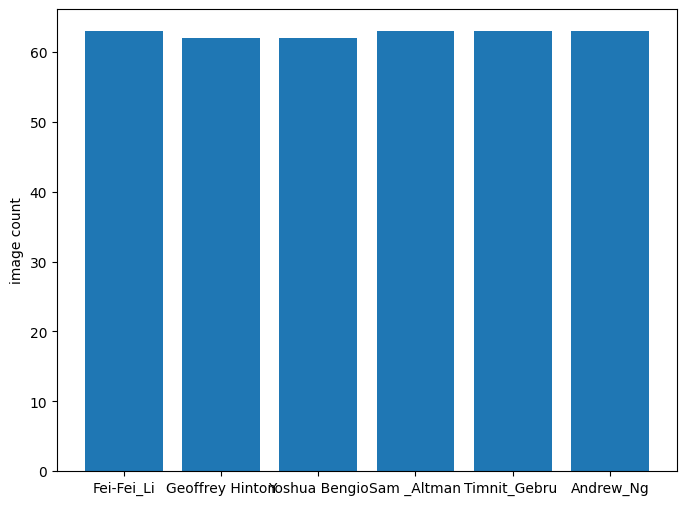

In [22]:
plt.figure(figsize=(8, 6))
plt.bar(list(celebrity_file_names_dict.keys()),[len(files) for files in celebrity_file_names_dict.values()]) 
plt.ylabel('image count')

Each class has 62 to 102 images.

In [32]:
celebrity_dict={}
celebrity_dict_reverse={}
i=0;
sorted_keys = sorted(celebrity_file_names_dict.keys())
for name in sorted_keys:
   celebrity_dict[i] =name
   celebrity_dict_reverse[name]=i
   i+=1

celebrity_dict


{0: 'Andrew_Ng',
 1: 'Fei-Fei_Li',
 2: 'Geoffrey Hinton',
 3: 'Sam _Altman',
 4: 'Timnit_Gebru ',
 5: 'Yoshua Bengio'}

### Data Augmentation

In [24]:
# Random rotation
def rotate_angle(img, angle=15):
   angle = np.random.randint(-angle, angle)  # Rotate between -15 to 15 degrees
   rows, cols, _ = img.shape
   M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
   img_aug = cv2.warpAffine(img, M, (cols, rows))
   return img_aug
def adjust_brightness(img, percantage=0.2):
   # Random brightness adjustment
   alpha = 1.0 + np.random.uniform(-percantage, percantage)  # Vary brightness between -20% to +20%
   img_aug = cv2.convertScaleAbs(img, alpha=alpha, beta=0)
   return img_aug

## Feature extraction method: Wawelet transform

Wawelet transform is a color normalization technique that reduces lighting variations and improves classification accuracy.

In [25]:
#thanks to stackoverflow 
def w2d(img, mode='haar', level=1):
    imArray = img
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    imArray =  np.float32(imArray)   
    imArray /= 255;
    coeffs=pywt.wavedec2(imArray, mode, level=level)
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

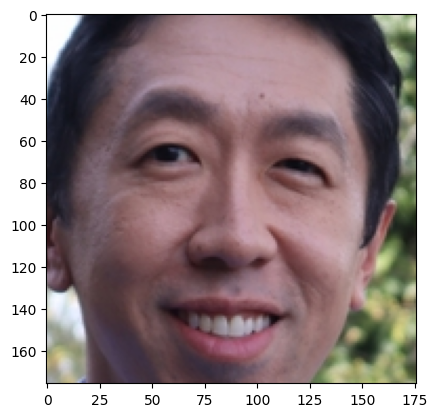

In [26]:
cropped_image=cv2.imread('cropped_images_final/Andrew_Ng/Andrew_Ng1.png')
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

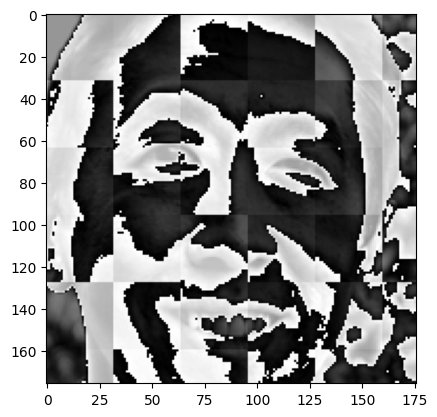

In [27]:
im_velvet = w2d(cropped_image,'db1',5)
plt.imshow(im_velvet, cmap='gray')

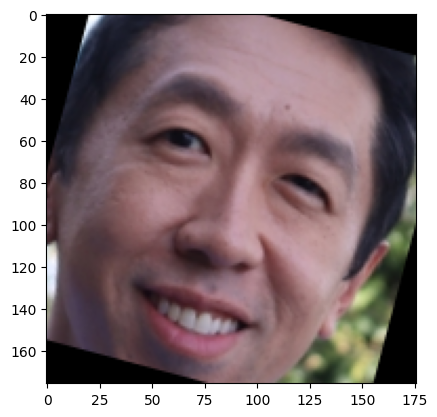

In [28]:
img_angle = rotate_angle(cropped_image)
plt.imshow(cv2.cvtColor(img_angle, cv2.COLOR_BGR2RGB))

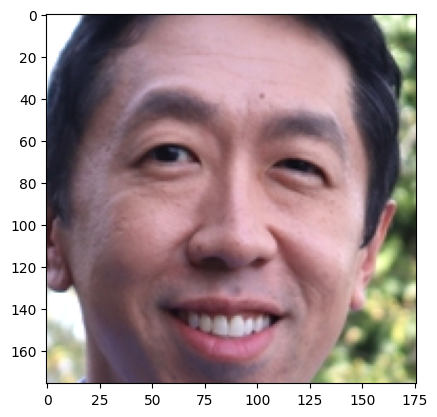

In [29]:
img_brightness = adjust_brightness(cropped_image)
plt.imshow(cv2.cvtColor(img_brightness, cv2.COLOR_BGR2RGB))

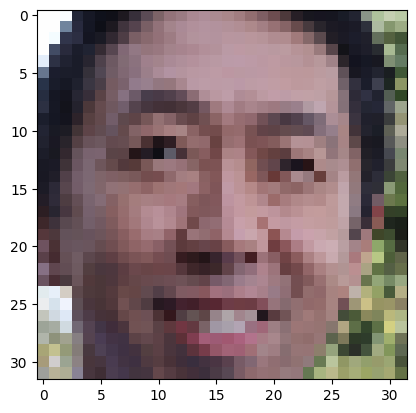

In [30]:
cropped_image_scaled = cv2.resize(cropped_image,(32,32))
plt.imshow(cv2.cvtColor(cropped_image_scaled, cv2.COLOR_BGR2RGB))

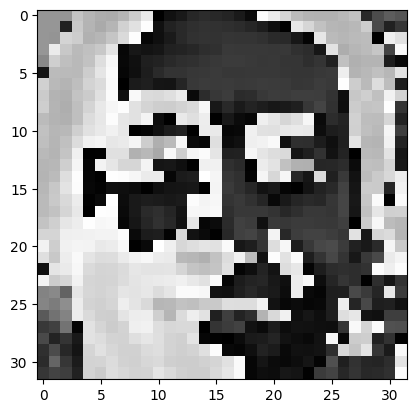

In [31]:
cropped_image_scaled_velvet = w2d(cropped_image_scaled,'db1',5)
plt.imshow(cv2.cvtColor(cropped_image_scaled_velvet, cv2.COLOR_BGR2RGB))

In [33]:
X=[]
y=[]
for celebrity_name, files in celebrity_file_names_dict.items():
   for img in files:
      img = cv2.imread(img)
      img = cv2.resize(img,(32,32))
      X.append(img)
      y.append(celebrity_dict_reverse[celebrity_name])


Convert to numpy array

In [16]:
X=np.array(X)
X=X.reshape(-1,32*32*3).astype(np.float32)
y=np.array(y)
X.shape


(1, 3072)

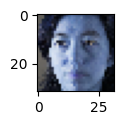

In [17]:
#np array => image
plt.figure(figsize=(1, 1))
plt.imshow(X[0].reshape(32,32,3).astype(np.uint8))

In [18]:
def augment_data_X(X):
    augmented_images = []
    for img in X:
        img_w2d = w2d(img.reshape(32,32,3).astype(np.uint8))
        combined_img = np.vstack((img.reshape(32*32*3,1),img_w2d.reshape(32*32,1)))
        augmented_images.append(combined_img)

        img_rot = rotate_angle(img.reshape(32,32,3).astype(np.uint8))
        img_rot_w2d = w2d(img_rot.reshape(32,32,3).astype(np.uint8))
        combined_img_rot = np.vstack((img_rot.reshape(32*32*3,1),img_rot_w2d.reshape(32*32,1)))
        augmented_images.append(combined_img_rot)

        img_bri = adjust_brightness(img.reshape(32,32,3).astype(np.uint8))
        img_bri_w2d = w2d(img_bri.reshape(32,32,3).astype(np.uint8))
        combined_img_bri = np.vstack((img_bri.reshape(32*32*3,1),img_bri_w2d.reshape(32*32,1)))
        augmented_images.append(combined_img_bri)
        
    augmented_images=np.array(augmented_images).reshape(-1,32*32*3+32*32).astype(np.float32)

    return augmented_images

In [19]:
def augment_data_y(y):
    augmented_labels = []
    for label in y:
        augmented_labels.append(label)
        augmented_labels.append(label)
        augmented_labels.append(label)
    return np.array(augmented_labels)

In [20]:
def velvet_data(X):
    images = []
    for img in X:
        img_w2d = w2d(img.reshape(32,32,3).astype(np.uint8))
        combined_img = np.vstack((img.reshape(32*32*3,1),img_w2d.reshape(32*32,1)))
        images.append(combined_img)
    images=np.array(images).reshape(-1,32*32*3+32*32).astype(np.float32)
    
    return images

In [21]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

np.random.seed(105)  



In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)
svc_rbf = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 1, random_state=101))])
svc_linear = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'linear', C = 10, random_state=102))])
random_forest = Pipeline([('scaler', StandardScaler()), ('RandomForestClassifier', RandomForestClassifier(n_estimators=10, random_state=103))])
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('XGBClassifier', XGBClassifier(n_estimators=100, random_state=100))
])
lr = Pipeline([('scaler', StandardScaler()), ('LogisticRegression', LogisticRegression(C=10, random_state=9,max_iter=500))])
pipelines=[svc_rbf, svc_linear, random_forest, xgb_pipeline, lr]

models_names = ['SVC_rbf', 'SVC_linear', 'RandomForestClassifier', 'XGBClassifier', 'LogisticRegression']

scores={}
best_estimators={}
best_accuracy={}
for model in models_names:
   best_accuracy[model] = 0
k_folds = 5 
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
j=0
for model in pipelines:
   models=[]
   accuracy=[]
   print(models_names[j])
   for fold, (train_indices, val_indices) in enumerate(kf.split(X_train)):
      X_train_cur, X_val = X_train[train_indices], X_train[val_indices]
      y_train_cur, y_val = y_train[train_indices], y_train[val_indices]
      X_train_cur = augment_data_X(X_train_cur)
      y_train_cur = augment_data_y(y_train_cur)
      X_val = velvet_data(X_val)
      model.fit(X_train_cur, y_train_cur)
      val_score = model.score(X_val, y_val)
      accuracy.append(val_score)
      models.append(model)
   score=[np.mean(accuracy),np.max(accuracy)]
   max_accuracy=np.max(accuracy)
   max_accuracy_ind=np.argmax(accuracy)
   if(max_accuracy>best_accuracy[models_names[j]]):
      best_accuracy[models_names[j]]=max_accuracy
      best_estimators[models_names[j]]=models[max_accuracy_ind]
   print(score)
   try:
      scores[models_names[j]].append(score)
   except KeyError:
      scores[models_names[j]]=[score]
   j=j+1
print()
   


SVC_rbf
[0.8899122807017544, 0.9122807017543859]
SVC_linear
[0.9077067669172931, 0.9298245614035088]
RandomForestClassifier
[0.7265037593984962, 0.8245614035087719]
XGBClassifier
[0.8366541353383459, 0.8947368421052632]
LogisticRegression
[0.9219298245614034, 0.9473684210526315]



Logistic Regression has the best accuracy

In [37]:
best_accuracy

{'SVC_rbf': 0.9122807017543859,
 'SVC_linear': 0.9298245614035088,
 'RandomForestClassifier': 0.8245614035087719,
 'XGBClassifier': 0.8947368421052632,
 'LogisticRegression': 0.9473684210526315}

In [38]:
X_test=velvet_data(X_test)
best_estimators['SVC_linear'].score(X_test,y_test)


0.9042553191489362

In [27]:
best_estimators['RandomForestClassifier'].score(X_test,y_test)


0.7340425531914894

In [28]:
best_model=best_estimators['LogisticRegression']
best_estimators['LogisticRegression'].score(X_test,y_test)

0.925531914893617

Text(95.72222222222221, 0.5, 'True')

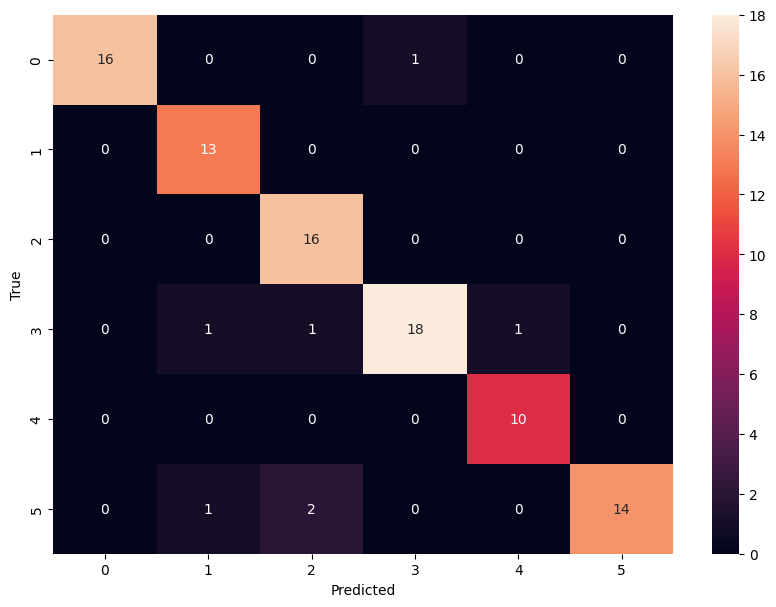

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(y_test, best_model.predict(X_test)), annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')

In [40]:
import joblib 
joblib.dump(best_model, 'model.pkl') 

['model.pkl']

In [46]:
import json
with open("celebrity_dictionary.json","w") as f:
    f.write(json.dumps(celebrity_dict))

In [241]:
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_eye.xml')
def predict(img_path):
      img_input = cv2.imread(img_path)
      gray = cv2.cvtColor(img_input, cv2.COLOR_BGR2GRAY)
      faces = face_cascade.detectMultiScale(gray, 1.3, 5)
      if(len(faces)==1):
            for (x,y,w,h) in faces:
              roi_gray = gray[y:y+h, x:x+w]
              roi_color = img_input[y:y+h, x:x+w]
              eyes = eye_cascade.detectMultiScale(roi_gray)
              if len(eyes) >= 2:
                  img=roi_color
                  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                  plt.title('Cropped Face')
                  plt.show()
                  img = cv2.resize(img,(32,32))
                  img_w2d = w2d(img.reshape(32,32,3).astype(np.uint8))
                  combined_img = np.vstack((img.reshape(32*32*3,1),img_w2d.reshape(32*32,1)))
                  return celebrity_dict[best_model.predict(combined_img.reshape(1,-1))[0]]
              elif len(eyes) == 1:
                   return 'Only one eye detected'
              else: return 'No eyes detected'
      elif(len(faces)>1):
           return 'More than one face detected'
      else:
           return 'Face not detected'

Text(0.5, 1.0, 'Test Image')

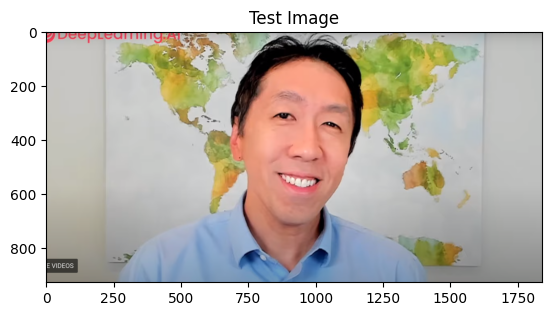

In [94]:
test_img=cv2.imread('dataset/test_image.png')
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.title('Test Image')

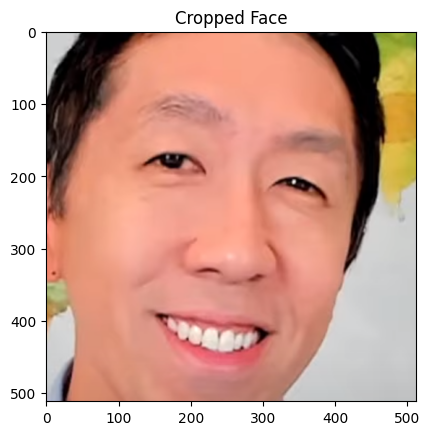

Andrew_Ng


In [95]:
print(predict('dataset/test_image.png'))


Text(0.5, 1.0, 'Test Image')

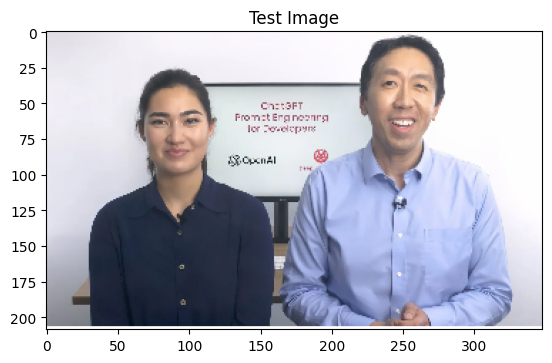

In [89]:
test_img=cv2.imread('dataset/test_image_2_faces.png')
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.title('Test Image')

In [90]:
print(predict('dataset/test_image_2_faces.png'))


More than one face detected


## Data preprocessing for CNN

In [35]:
import tensorflow as tf
from keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

2024-03-29 14:47:04.774819: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-29 14:47:04.776822: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-29 14:47:04.801189: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 14:47:04.801221: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 14:47:04.801238: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [150]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [215]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "cropped_images_final_balanced",
    seed=42,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
celebrity_dict

Found 376 files belonging to 6 classes.


{0: 'Andrew_Ng',
 1: 'Fei-Fei_Li',
 2: 'Geoffrey Hinton',
 3: 'Sam _Altman',
 4: 'Timnit_Gebru ',
 5: 'Yoshua Bengio'}

Visualize Dataset

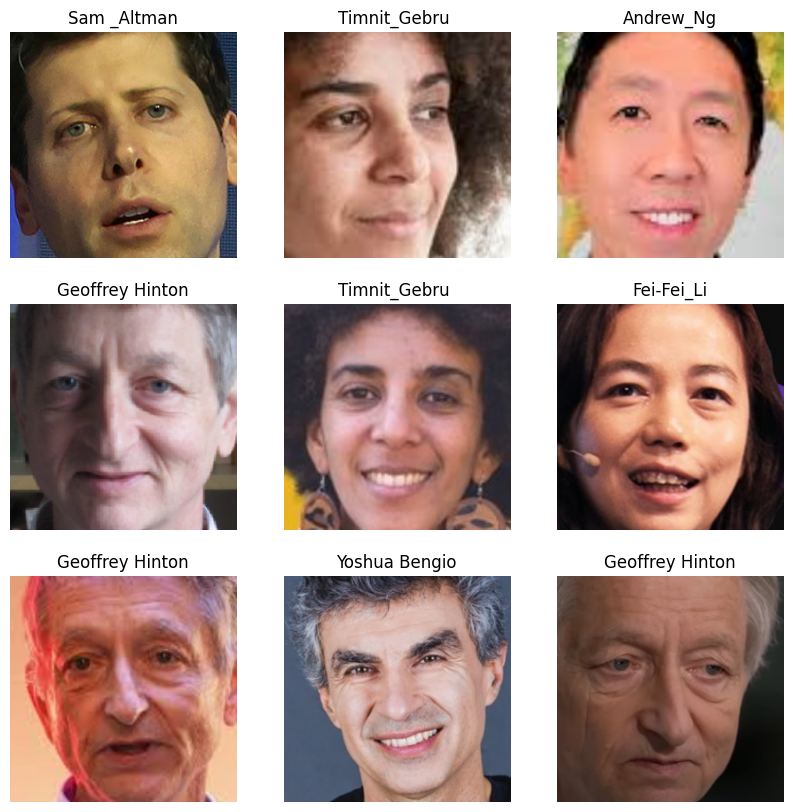

In [214]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(celebrity_dict[labels_batch[i].numpy()])
        plt.axis("off")

Split to training, validation and test sets

In [153]:
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
dataset = dataset.shuffle(buffer_size=len(dataset), seed=50)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size).skip(val_size)

In [154]:
len(train_dataset)*BATCH_SIZE

288

### Prefetch and cache

In [155]:

train_dataset = train_dataset.cache().shuffle(dataset_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(dataset_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(dataset_size).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the model

In [156]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomContrast(factor=0.2),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [157]:
test_dataset.take(1).map(lambda image, label: (resize_and_rescale(image), label))


<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### Data Augmentation for the training dataset

In [158]:
train_ds = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture
I'll use CNN coupled with a Softmax activation in the output layer. Additionally, I'll incorporate initial layers for resizing, normalization, and Data Augmentation.

In [159]:
tf.random.set_seed(20)
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model_cnn = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(input_shape)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(96, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model_cnn.build(input_shape=input_shape)

In [160]:
model_cnn.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_20 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_78 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_78 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_5 (Bat  (32, 127, 127, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_79 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_79 (MaxPooli  (32, 62, 62, 64)        

In [161]:
from keras import optimizers, losses
model_cnn.compile(
    optimizer=optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history = model_cnn.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    verbose=1,
    epochs=30
)

Epoch 1/30
9/9 [==============================] - 8s 636ms/step - loss: 2.0436 - accuracy: 0.2893 - val_loss: 1.7993 - val_accuracy: 0.1250
Epoch 2/30
9/9 [==============================] - 5s 574ms/step - loss: 1.3370 - accuracy: 0.5036 - val_loss: 1.7773 - val_accuracy: 0.2188
Epoch 3/30
9/9 [==============================] - 5s 574ms/step - loss: 1.0777 - accuracy: 0.6000 - val_loss: 1.8495 - val_accuracy: 0.2188
Epoch 4/30
9/9 [==============================] - 5s 549ms/step - loss: 0.8934 - accuracy: 0.6893 - val_loss: 1.9240 - val_accuracy: 0.2188
Epoch 5/30
9/9 [==============================] - 5s 535ms/step - loss: 0.7562 - accuracy: 0.7071 - val_loss: 2.1446 - val_accuracy: 0.2188
Epoch 6/30
9/9 [==============================] - 5s 538ms/step - loss: 0.6569 - accuracy: 0.7464 - val_loss: 2.3258 - val_accuracy: 0.2188
Epoch 7/30
9/9 [==============================] - 5s 535ms/step - loss: 0.5452 - accuracy: 0.8214 - val_loss: 2.3672 - val_accuracy: 0.2188
Epoch 8/30
9/9 [====

In [162]:
score=model_cnn.evaluate(test_dataset)

2/2 [==============================] - 1s 166ms/step - loss: 2.2120 - accuracy: 0.4844


In [163]:
history = model_cnn.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    verbose=1,
    epochs=30
)

Epoch 1/30
9/9 [==============================] - 5s 563ms/step - loss: 0.1031 - accuracy: 0.9679 - val_loss: 1.5430 - val_accuracy: 0.4375
Epoch 2/30
9/9 [==============================] - 5s 561ms/step - loss: 0.0745 - accuracy: 0.9750 - val_loss: 1.4648 - val_accuracy: 0.4375
Epoch 3/30
9/9 [==============================] - 5s 530ms/step - loss: 0.0902 - accuracy: 0.9643 - val_loss: 1.8155 - val_accuracy: 0.4688
Epoch 4/30
9/9 [==============================] - 5s 534ms/step - loss: 0.0616 - accuracy: 0.9750 - val_loss: 1.0800 - val_accuracy: 0.5625
Epoch 5/30
9/9 [==============================] - 5s 549ms/step - loss: 0.0916 - accuracy: 0.9714 - val_loss: 0.7652 - val_accuracy: 0.7812
Epoch 6/30
9/9 [==============================] - 5s 527ms/step - loss: 0.0441 - accuracy: 0.9929 - val_loss: 1.0273 - val_accuracy: 0.6562
Epoch 7/30
9/9 [==============================] - 5s 565ms/step - loss: 0.0772 - accuracy: 0.9821 - val_loss: 0.8991 - val_accuracy: 0.5938
Epoch 8/30
9/9 [====

In [167]:
score=model_cnn.evaluate(test_dataset)

2/2 [==============================] - 0s 157ms/step - loss: 0.1677 - accuracy: 0.9531


In [165]:
history = model_cnn.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    verbose=1,
    epochs=10
)

Epoch 1/10
9/9 [==============================] - 5s 564ms/step - loss: 0.0635 - accuracy: 0.9714 - val_loss: 0.4165 - val_accuracy: 0.8750
Epoch 2/10
9/9 [==============================] - 5s 559ms/step - loss: 0.0532 - accuracy: 0.9893 - val_loss: 0.1839 - val_accuracy: 0.9375
Epoch 3/10
9/9 [==============================] - 5s 549ms/step - loss: 0.0740 - accuracy: 0.9786 - val_loss: 0.1057 - val_accuracy: 0.9688
Epoch 4/10
9/9 [==============================] - 5s 544ms/step - loss: 0.0383 - accuracy: 0.9893 - val_loss: 0.0907 - val_accuracy: 0.9688
Epoch 5/10
9/9 [==============================] - 5s 535ms/step - loss: 0.0240 - accuracy: 1.0000 - val_loss: 0.1196 - val_accuracy: 0.9688
Epoch 6/10
9/9 [==============================] - 5s 537ms/step - loss: 0.0363 - accuracy: 0.9893 - val_loss: 0.1675 - val_accuracy: 0.9062
Epoch 7/10
9/9 [==============================] - 5s 539ms/step - loss: 0.0331 - accuracy: 0.9964 - val_loss: 0.1049 - val_accuracy: 0.9688
Epoch 8/10
9/9 [====

In [169]:
history = model_cnn.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    verbose=1,
    epochs=10
)

Epoch 1/10
9/9 [==============================] - 5s 592ms/step - loss: 0.0555 - accuracy: 0.9679 - val_loss: 1.7555 - val_accuracy: 0.5938
Epoch 2/10
9/9 [==============================] - 5s 564ms/step - loss: 0.0581 - accuracy: 0.9786 - val_loss: 0.9222 - val_accuracy: 0.7812
Epoch 3/10
9/9 [==============================] - 5s 577ms/step - loss: 0.0531 - accuracy: 0.9750 - val_loss: 0.1089 - val_accuracy: 0.9688
Epoch 4/10
9/9 [==============================] - 6s 592ms/step - loss: 0.0680 - accuracy: 0.9857 - val_loss: 0.0154 - val_accuracy: 1.0000
Epoch 5/10
9/9 [==============================] - 5s 571ms/step - loss: 0.0747 - accuracy: 0.9679 - val_loss: 0.0157 - val_accuracy: 1.0000
Epoch 6/10
9/9 [==============================] - 5s 565ms/step - loss: 0.0448 - accuracy: 0.9857 - val_loss: 0.0575 - val_accuracy: 0.9688
Epoch 7/10
9/9 [==============================] - 5s 577ms/step - loss: 0.0521 - accuracy: 0.9821 - val_loss: 0.0479 - val_accuracy: 1.0000
Epoch 8/10
9/9 [====

In [172]:
score=model_cnn.evaluate(test_dataset)

2/2 [==============================] - 0s 149ms/step


In [171]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model_cnn.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/4/assets


INFO:tensorflow:Assets written to: models/4/assets


In [199]:
face_cascade = cv2.CascadeClassifier("haarcascades/haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier("haarcascades/haarcascade_eye.xml")
def predict_cnn(model, img_input):
    gray = cv2.cvtColor(img_input, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if(len(faces)==1):
          for (x,y,w,h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img_input[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray)
            if len(eyes) >= 2:
                img=roi_color
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                plt.title('Cropped Face')
                plt.show()
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                img_array = tf.expand_dims(img_array, 0)
                predictions = model.predict(img_array)
                predicted_class = celebrity_dict[np.argmax(predictions[0])]
                confidence = round(100 * (np.max(predictions[0])), 2)
                return predicted_class, confidence
            elif len(eyes) == 1:
                 return 'Only one eye detected'
            else: return 'No eyes detected'
    elif(len(faces)>1):
         return 'More than one face detected'
    else:
           return 'Face not detected'


2/2 [==============================] - 0s 160ms/step


Text(95.72222222222221, 0.5, 'Truth')

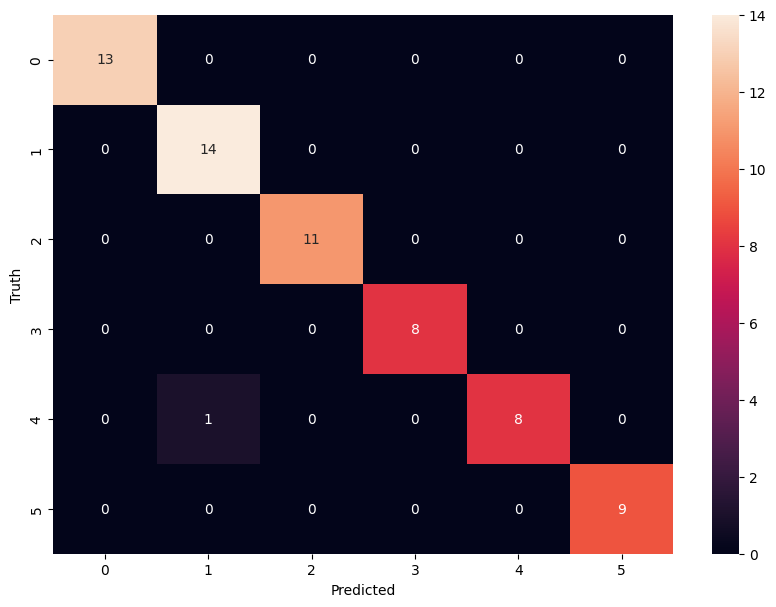

In [200]:
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

predictions = model_cnn.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)
cm = confusion_matrix(true_labels, predicted_labels)

import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')


Let's test out prediction function! I've took screenshots from videos with these celebrities, they weren't in the dataset.

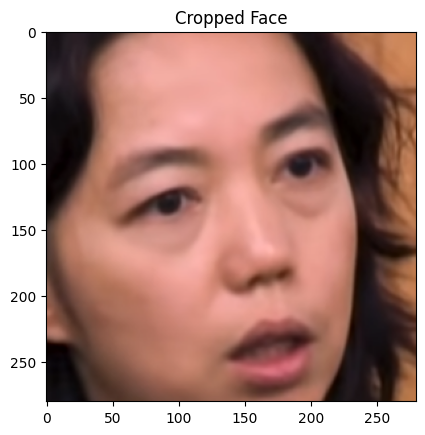

1/1 [==============================] - 0s 20ms/step


('Timnit_Gebru ', 100.0)

In [212]:
img=cv2.imread('/home/mallahova/Pictures/1.png')

predict_cnn(model_cnn, img)

In [213]:
celebrity_dict

{0: 'Andrew_Ng',
 1: 'Fei-Fei_Li',
 2: 'Geoffrey Hinton',
 3: 'Sam _Altman',
 4: 'Timnit_Gebru ',
 5: 'Yoshua Bengio'}

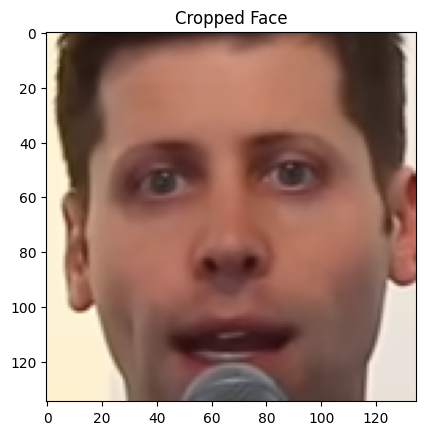

1/1 [==============================] - 0s 20ms/step


('Timnit_Gebru ', 62.75)

In [202]:
img=cv2.imread('dataset/test_image_2.png')
predict_cnn(model_cnn, img)

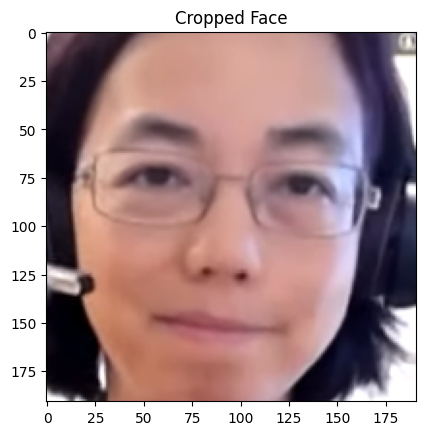

1/1 [==============================] - 0s 20ms/step


('Fei-Fei_Li', 82.24)

In [203]:
img=cv2.imread('dataset/test_image_3.png')

predict_cnn(model_cnn, img)

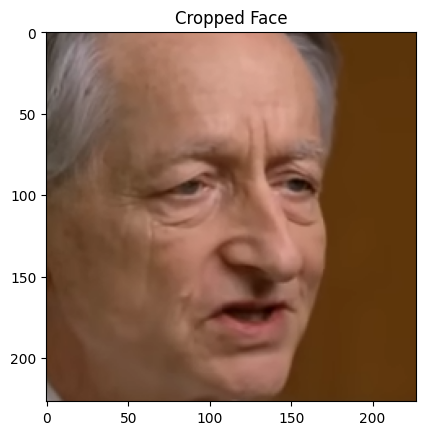

1/1 [==============================] - 0s 22ms/step


('Geoffrey Hinton', 91.7)

In [204]:
img=cv2.imread('dataset/test_image_4.png')

predict_cnn(model_cnn, img)